In [278]:
##### import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score, confusion_matrix, plot_confusion_matrix
from sklearn.inspection import permutation_importance

In [279]:
##### random seeds
random_state = 10


##### models: hyperparameters (parameters were optimized after two rounds of selection)
##### random forest
n_estimators = [300] #[100, 200, 300, 400, 500, ,750, 1000]
max_depth = [None] #[None, 2, 4, 5]
max_features = ['auto'] #['auto', 2]
min_samples_leaf = [1] #[1, 2, 3]
oob_score = [True]
param_grid_rf = {'n_estimators': n_estimators,
                 'max_depth': max_depth,
                 'max_features': max_features,
                 'min_samples_leaf': min_samples_leaf,
                 'oob_score': oob_score}

##### gradient boosting classifier
n_estimators = [4500] #[100, 200, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4250, 4500, 4750]
learning_rate = [0.05] #[0.1, 0.075, 0.05, 0.025, 0.01]
max_depth = [5] #[2, 5, 7, 10]
subsample = [0.15] #[0.1, 0.15, 0.2]
max_features = ['auto'] #['auto', 2, 3]
param_grid_gbr = {'n_estimators': n_estimators,
                  'learning_rate': learning_rate,
                  'max_depth': max_depth,
                  'max_features': max_features,
                  'subsample': subsample}

In [280]:
def pricing(x):
    if x >= 0 and x < 500000:
        return 0
    elif x >= 500000 and x < 1000000:
        return 1
    else: ### x >= 1000000
        return 2

def grid_search_cv(estimator, param_grid, X_train, y_train):
    grid_search = GridSearchCV(estimator, param_grid, cv = 5, verbose = 2, n_jobs = -1)
    grid_search.fit(X_train, y_train)
    print('best parameters:', grid_search.best_params_)
    return grid_search.best_estimator_, grid_search.best_params_ # , grid_search.cv_results_

def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    #mae = mean_absolute_error(y_test, y_pred)
    #mse = mean_squared_error(y_test, y_pred)
    #rmse = np.sqrt(mse)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')

    print('accuracy: {:0.6f}'.format(accuracy))
    print('precision: {:0.6f}'.format(precision))
    print('recall: {:0.6f}'.format(recall))
    #print('mse: {:0.6f}'.format(mse))
    #print('rmse: {:0.6f}'.format(rmse))
    #print('r2: {:0.6f}'.format(r2))
    return accuracy, y_pred, precision, recall


def classify_model(model, param_grid, X_train, X_test, y_train, y_test):
    best_grid = grid_search_cv(model, param_grid, X_train, y_train)
    print(best_grid[0])
    
    ##### evaluate the optimal model
    print('Train dataset:')
    train_result = evaluate(best_grid[0], X_train, y_train)
    print('Test dataset:')
    test_result = evaluate(best_grid[0], X_test, y_test)
    return best_grid, train_result, test_result

In [281]:
##### dataset
modified = pd.read_csv("../data/modified_data.csv")
modified.head()

,image_id,street,city,city_code,bed,bath,sqft,price
0,0,1317 Van Buren Avenue,"Salton City, CA",317,3,2.0,1560,201900
1,1,124 C Street W,"Brawley, CA",48,3,2.0,713,228500
2,2,2304 Clark Road,"Imperial, CA",152,3,1.0,800,273950
3,3,755 Brawley Avenue,"Brawley, CA",48,3,1.0,1082,350000
4,4,2207 R Carrillo Court,"Calexico, CA",55,4,3.0,2547,385100


In [282]:
##### copy dataset
data = modified.copy()

In [283]:
##### set price range
data['price_range'] = data['price'].apply(pricing)

In [284]:
data

,image_id,street,city,city_code,bed,bath,sqft,price,price_range
0,0,1317 Van Buren Avenue,"Salton City, CA",317,3,2.0,1560,201900,0
1,1,124 C Street W,"Brawley, CA",48,3,2.0,713,228500,0
2,2,2304 Clark Road,"Imperial, CA",152,3,1.0,800,273950,0
3,3,755 Brawley Avenue,"Brawley, CA",48,3,1.0,1082,350000,0
4,4,2207 R Carrillo Court,"Calexico, CA",55,4,3.0,2547,385100,0
...,...,...,...,...,...,...,...,...,...
15469,15469,4156 Sterlingview Drive,"Moorpark, CA",227,5,4.1,4092,949000,1
15470,15470,4355 Avenida Prado,"Thousand Oaks, CA",372,5,3.0,2773,949900,1
15471,15471,12717 Koenigstein Rd Road,"Santa Paula, CA",338,3,2.0,1576,920000,1
15472,15472,36 Kunkle Street,"Oak View, CA",253,4,2.0,2086,997000,1


In [285]:
##### independent variables and dependent variable
X=data.drop(['image_id', 'street', 'city', 'price', 'price_range'], axis=1)
y=data['price_range']
y=np.array(y)

In [286]:
##### split data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = random_state)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(10831, 4)
(4643, 4)
(10831,)
(4643,)


In [287]:
##### models
model_rf, train_result_rf, test_result_rf = classify_model(RandomForestClassifier(random_state=random_state, verbose=1), param_grid_rf, X_train, X_test,  y_train, y_test)
model_gbr, train_result_gbr, test_result_gbr = classify_model(GradientBoostingClassifier(random_state=random_state, verbose=1), param_grid_gbr, X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    3.2s finished


best parameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 300, 'oob_score': True}
RandomForestClassifier(n_estimators=300, oob_score=True, random_state=10,
                       verbose=1)
Train dataset:


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


accuracy: 0.998246
precision: 0.998544
recall: 0.998162
Test dataset:


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.3s finished


accuracy: 0.779884
precision: 0.760217
recall: 0.711314
Fitting 5 folds for each of 1 candidates, totalling 5 fits
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.9497           0.0197            1.33m
         2           0.9258           0.0176            1.31m
         3           0.9187           0.0157            1.29m
         4           0.8912           0.0149            1.29m
         5           0.8709           0.0130            1.29m
         6           0.8795           0.0119            1.28m
         7           0.8567           0.0099            1.28m
         8           0.8599           0.0092            1.28m
         9           0.8304           0.0094            1.28m
        10           0.8354           0.0087            1.30m
        20           0.7680           0.0043            1.36m
        30           0.7224           0.0029            1.39m
        40           0.6914           0.0031            1.39m
        50      

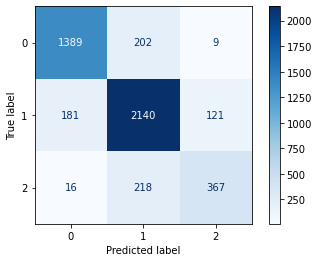

In [288]:
cm = confusion_matrix(y_test, test_result_gbr[1])
plot_confusion_matrix(model_gbr[0], X_test, y_test, cmap=plt.cm.Blues)  
plt.show()

In [289]:
test_result_gbr

(0.8391126426879173,
 array([1, 0, 1, ..., 0, 0, 1]),
 0.8167187432603185,
 0.7850349316000315)

In [290]:
test_result_rf

(0.7798836958862804,
 array([1, 0, 1, ..., 0, 0, 1]),
 0.7602170331125002,
 0.711313990968733)